In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import torch

from torch.utils.data import Dataset, DataLoader

In [2]:
DATA_ROOT = pathlib.Path("../../data")
INPUTS_DIR = DATA_ROOT / "input"
DATASET_DIR = INPUTS_DIR / "mayo-clinic-strip-ai"

TRAIN_TIFF_DIR = DATASET_DIR / "train"
TEST_TIFF_DIR = DATASET_DIR / "test"
OUTPUT_DIR = DATA_ROOT / "working"
EMBEDDINGS_DIR = INPUTS_DIR / "embs"
FG_IDS_DIR = INPUTS_DIR / "fg_ids"
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
EMB_SIZE = 512
BATCH_SIZE = 64

In [3]:
input_df = pd.read_csv(DATASET_DIR / "train.csv")

labels_dict = {"CE": 0, "LAA": 1}

def label_to_int(x):
    return labels_dict[x["label"]]
input_df["label_int"] = input_df.apply(label_to_int, axis=1)

slide_paths = [TRAIN_TIFF_DIR / (x + ".tif" ) for x in input_df["image_id"]]
foreground_ids_dir = OUTPUT_DIR / "fg_ids"
downscaled_dir = OUTPUT_DIR / "downscaled"

In [4]:
slide_ids = []
for path in TRAIN_TIFF_DIR.glob("*.tif"):
    slide_ids.append(".".join(path.name.split(".")[:-1]))

input_df = input_df[input_df["image_id"].isin(slide_ids)]

In [5]:
embs = []
for _, sample in input_df.iterrows():
    embs.append(np.load(EMBEDDINGS_DIR / (sample.image_id + ".npy")))
    

In [6]:
[x.shape[0] for x in embs]

[3726, 230, 130, 8341, 425]

In [269]:
class CoarseDataset(Dataset):
    
    def __init__(self, dataframe, embs_dir, seq_length=0, pad_emb=None):
        super().__init__()
        self.dataframe = dataframe
        self.embs_dir = embs_dir
        self.pad_emb = pad_emb       
        self.embs_paths = [embs_dir / (x + ".npy" )for x in dataframe["image_id"]]
        self.n_embs = len(self.embs_paths)
        self.seq_length = seq_length
        
    def get_seq_length(self):
        max_l = 0
        for embs_path in self.embs_paths:
            embs = np.load(embs_path, allow_pickle=False)
            if max_l < embs.shape[0]:
                max_l = embs.shape[0]        
        return max_l
    
    def __len__(self):
        return self.n_embs
    
    def embs_to_length(self, embs, to_length, pad_vector=None):
        emb_length, emb_size = embs.shape
        if pad_vector is None:
            pad_vector = torch.zeros(emb_size)

        pad_size = to_length - emb_length
        if pad_size > 0:
            padding = torch.stack([pad_vector.T]*pad_size)
            embs = torch.concat([embs, padding], 0)

        return embs[0:to_length,:]
    
    def __getitem__(self, idx):
        embs = np.load(self.embs_paths[idx], allow_pickle=False)
        embs = torch.from_numpy(embs)
        label = train_df.iloc[idx]["label_int"]
        return {"embs": embs, "label": label}
    
    def collate_fn(self, samples):
        max_length = np.max([x["embs"].shape[0] for x in samples])
        labels = torch.tensor([x["label"] for x in samples], dtype=torch.long)
        in_batch = torch.stack([self.embs_to_length(x["embs"], max_length) for x in samples])
        return {"embs": in_batch, "label": labels}

In [270]:
embs_slides = []
norms = []
for path in EMBEDDINGS_DIR.glob("*npy"):
    embs = np.load(path, allow_pickle=False)
    embs_slides.append(embs.shape[0])
    norms.append(np.sqrt(np.sum(np.square(embs), 1)))

norms = np.concatenate(norms)

In [271]:
norms.shape

(12852,)

In [272]:
max(norms)

322.6744

<BarContainer object of 70 artists>

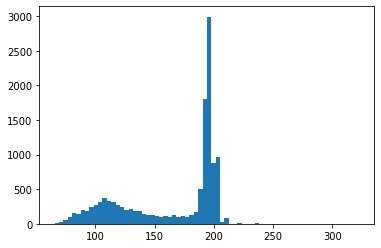

In [273]:
plt.hist(norms, bins=70)[-1]

In [274]:
from torch import nn

In [275]:
class CoarseTransformer(nn.Module):
    
    def __init__(self,emb_size, nhead, num_layers, num_classes=2, dim_feedforward=2048):
        super().__init__()
        enc_layer = nn.TransformerEncoderLayer(
            d_model=emb_size, 
            nhead=nhead,
            dim_feedforward=dim_feedforward, 
            batch_first=True
        )
        self.feature_extractor = nn.TransformerEncoder(
            encoder_layer=enc_layer, 
            num_layers=num_layers
        )
        self.pooler = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(emb_size, num_classes)
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.permute(0,2,1).contiguous()
        x = self.pooler(x).squeeze().contiguous()
        x = self.classifier(x)
        return x
    
coarse_model = CoarseTransformer(512, nhead=4, num_layers=2)

In [276]:
skf = StratifiedKFold(n_splits=2, shuffle=True)
train_folds = []
val_folds = []
for train_ids, val_ids in  skf.split(input_df, input_df.label_int):
    train_folds.append(train_ids)
    val_folds.append(val_ids)
    
split_id = 0
train_ids = train_folds[split_id]
val_ids = val_folds[split_id]
train_df = input_df.iloc[train_ids]
val_df = input_df.iloc[val_ids]

In [277]:
seq_length = 10
batch_size = 128
train_dataset = CoarseDataset(train_df, EMBEDDINGS_DIR, seq_length=seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=train_dataset.collate_fn)

val_dataset = CoarseDataset(val_df, EMBEDDINGS_DIR, seq_length=seq_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=val_dataset.collate_fn)

In [278]:
train_dataset = CoarseDataset(input_df, EMBEDDINGS_DIR, seq_length=seq_length)

In [279]:
batch = next(iter(train_loader))

In [281]:
batch["label"].dtype

torch.int64

In [287]:
NUM_EPOCHS = 10
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
WEIGHTS = (1,1)
optimiser = torch.optim.Adam(coarse_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(WEIGHTS, dtype=torch.float))

for epoch_i in range(NUM_EPOCHS):
    for batch in train_loader:
        outputs = coarse_model(batch["embs"])
        loss = criterion(outputs, batch["label"])
        loss.backward()
        optimiser.step()

In [288]:
labels = batch["label"].float()

In [289]:
criterion

CrossEntropyLoss()

In [290]:
loss = criterion(outputs, batch["label"])

In [158]:
batch.shape

torch.Size([2, 230, 512])

In [157]:
.shape

SyntaxError: invalid syntax (1189770672.py, line 1)